<a href="https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/demo/03_activity_evolution_trajectory_aw2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Software Introspection for Signaling Emergent Cyber-Social Operations (SIGNAL) 

## `LKML Activity Context Evolution`

**In support of DARPA AIE Hybrid AI to Protect Integrity of Open-Source Code (SocialCyber)**

This project is under the GPL3 License. See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

**Copyright 2022 SRI International.**

# 🏃‍♀️ Quickstart

## 🪄 Install `needed` libraries


In [ ]:
# Quietly clone the funcs repo
!git clone https://github.com/hsanchez/funcs.git &> /dev/null

In [ ]:
import os
os.chdir(f'./funcs')
# !git fetch
# !git checkout fixes_trust_in_motion &> /dev/null

In [ ]:
import funcs as utils

In [ ]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
import warnings

In [ ]:
try:
  # Huggingface's Accelerator
  from accelerate import Accelerator
except:
  !pip install accelerate
  from accelerate import Accelerator

## ✍ Set `needed` configuration

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
from IPython import get_ipython
utils.common.set_default_vars(os.environ, ipython_val=get_ipython())

In [ ]:
utils.dl.set_random_seed(2222)

## 🧹 Data cleaning and preparation

This section takes the developer activity data we have generated in Milestone 3 (using factor analysis) and prepare them to temporal embedding generation.

These developer data have been relabeled to account for both the developer who performed the activity and the topology of communication structure (e.g., socio-technical graph created from email threads). E.g., a `code_contribution` activity performed by a developer named `John Doe` within stringy email thread would be relabeled as `code_contribution_John_Doe_stringy`.  

In [ ]:
activity_data_file = "../data/activity_triplets_V1_02182022.csv'"
maintainers_data_file = "../data/maintainers.csv'"
if utils.common.is_run_in_colab():
  activity_data_file = utils.gdrive.get_dataset('activity_triplets_V1_02182022', False)
  maintainers_data_file = utils.gdrive.get_dataset('maintainers', False)

activity_df = pd.read_csv(activity_data_file, sep='\t')
activity_df = activity_df.loc[:, ~activity_df.columns.str.contains('^Unnamed')]
activity_df['sent_time'] = pd.to_datetime(activity_df['sent_time'], utc=True)
# sort the content of the DataFrame by 'sent_time'
activity_df = activity_df.sort_values(by=['sent_time'])
maintainer_df = pd.read_csv(maintainers_data_file,sep='\t')
maintainer_df['val'] = maintainer_df['val'].str.replace(' ','_')

In [ ]:
activity_df.head(1)

,sender_id,sent_time,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Composite Index,Rank,Status,comb_2,comb_3,is_triage,is_bug_fix,is_controversial,activity_label,project_thread,sendername_thread,triplet_one,triplet_two
24091,0,2020-08-20 09:35:52+00:00,0.262744,0.002416,0.000969,0.032951,0.022704,0.321784,24092.0,Below,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown


In [ ]:
maintainer_df.head(1)

,val
0,Dong_Aisheng


### Get developer activities performed by inviduals involved in the Hypocrite Commits incident.

First, we start with the University of Minnesota inviduals and then with a few LK maintainers (Selected because their activities occurred within the same timeframe).

In [ ]:
contributor_prefixes = ['Qiushi', 'Aditya_', 'George_Acosta', 'Acosta', 'James_Bond', 'Qiushi_Wu']
maintainers_prefixes = ['Kangjie', 'Herbert_Xu', 'David_S._Miller', 'Christophe_JAILLET', 
                        'Gustavo_A._R._Silva', 'Phani_Kiran_Hemadri', 'Greg_Kroah-Hartman', 
                        'Jiri_Slaby', 'Andrew_Morton', 'Kees_Cook', 'Michel_Lespinasse', 
                        'Vlastimil_Babka', 'Denis_Efremov', 'Ben_Hutchings', 'Jiri_Slaby', 
                        'Matt_Porter', 'Alexandre_Bounine', 'John_Hubbard', 
                        'Madhuparna_Bhowmik', 'Dan_Carpenter', 'Miquel_Raynal', 'Mike_Waychison',
                        'Ahmad_Fatoum', 'Al_Cooper', 'Alain_Volmat', 'Alan_Stern',
                        'Alan_Stern', 'Alban_Bedel', 'Alex_Elder', 'Alex_Eldern',
                        'Alex_Shi', 'Andreas_Gruenbacher', 'Andrew_Jeffery', 'Andrew_Lunn',
                        'Viresh_Kumar', 'Vivek_Goyal', 'Vladimir_Ol', 'Vladimir_Oltea', 'Vladimir_Vid',
                        'Vladimir_Zapols', 'Vlastimil_Babka_', 'Waiman_Long', 'Wei_Liu_u', 'Wei_Xu', 'Weili_Qian',]

Output()

Output()

Output()

Output()

Output()

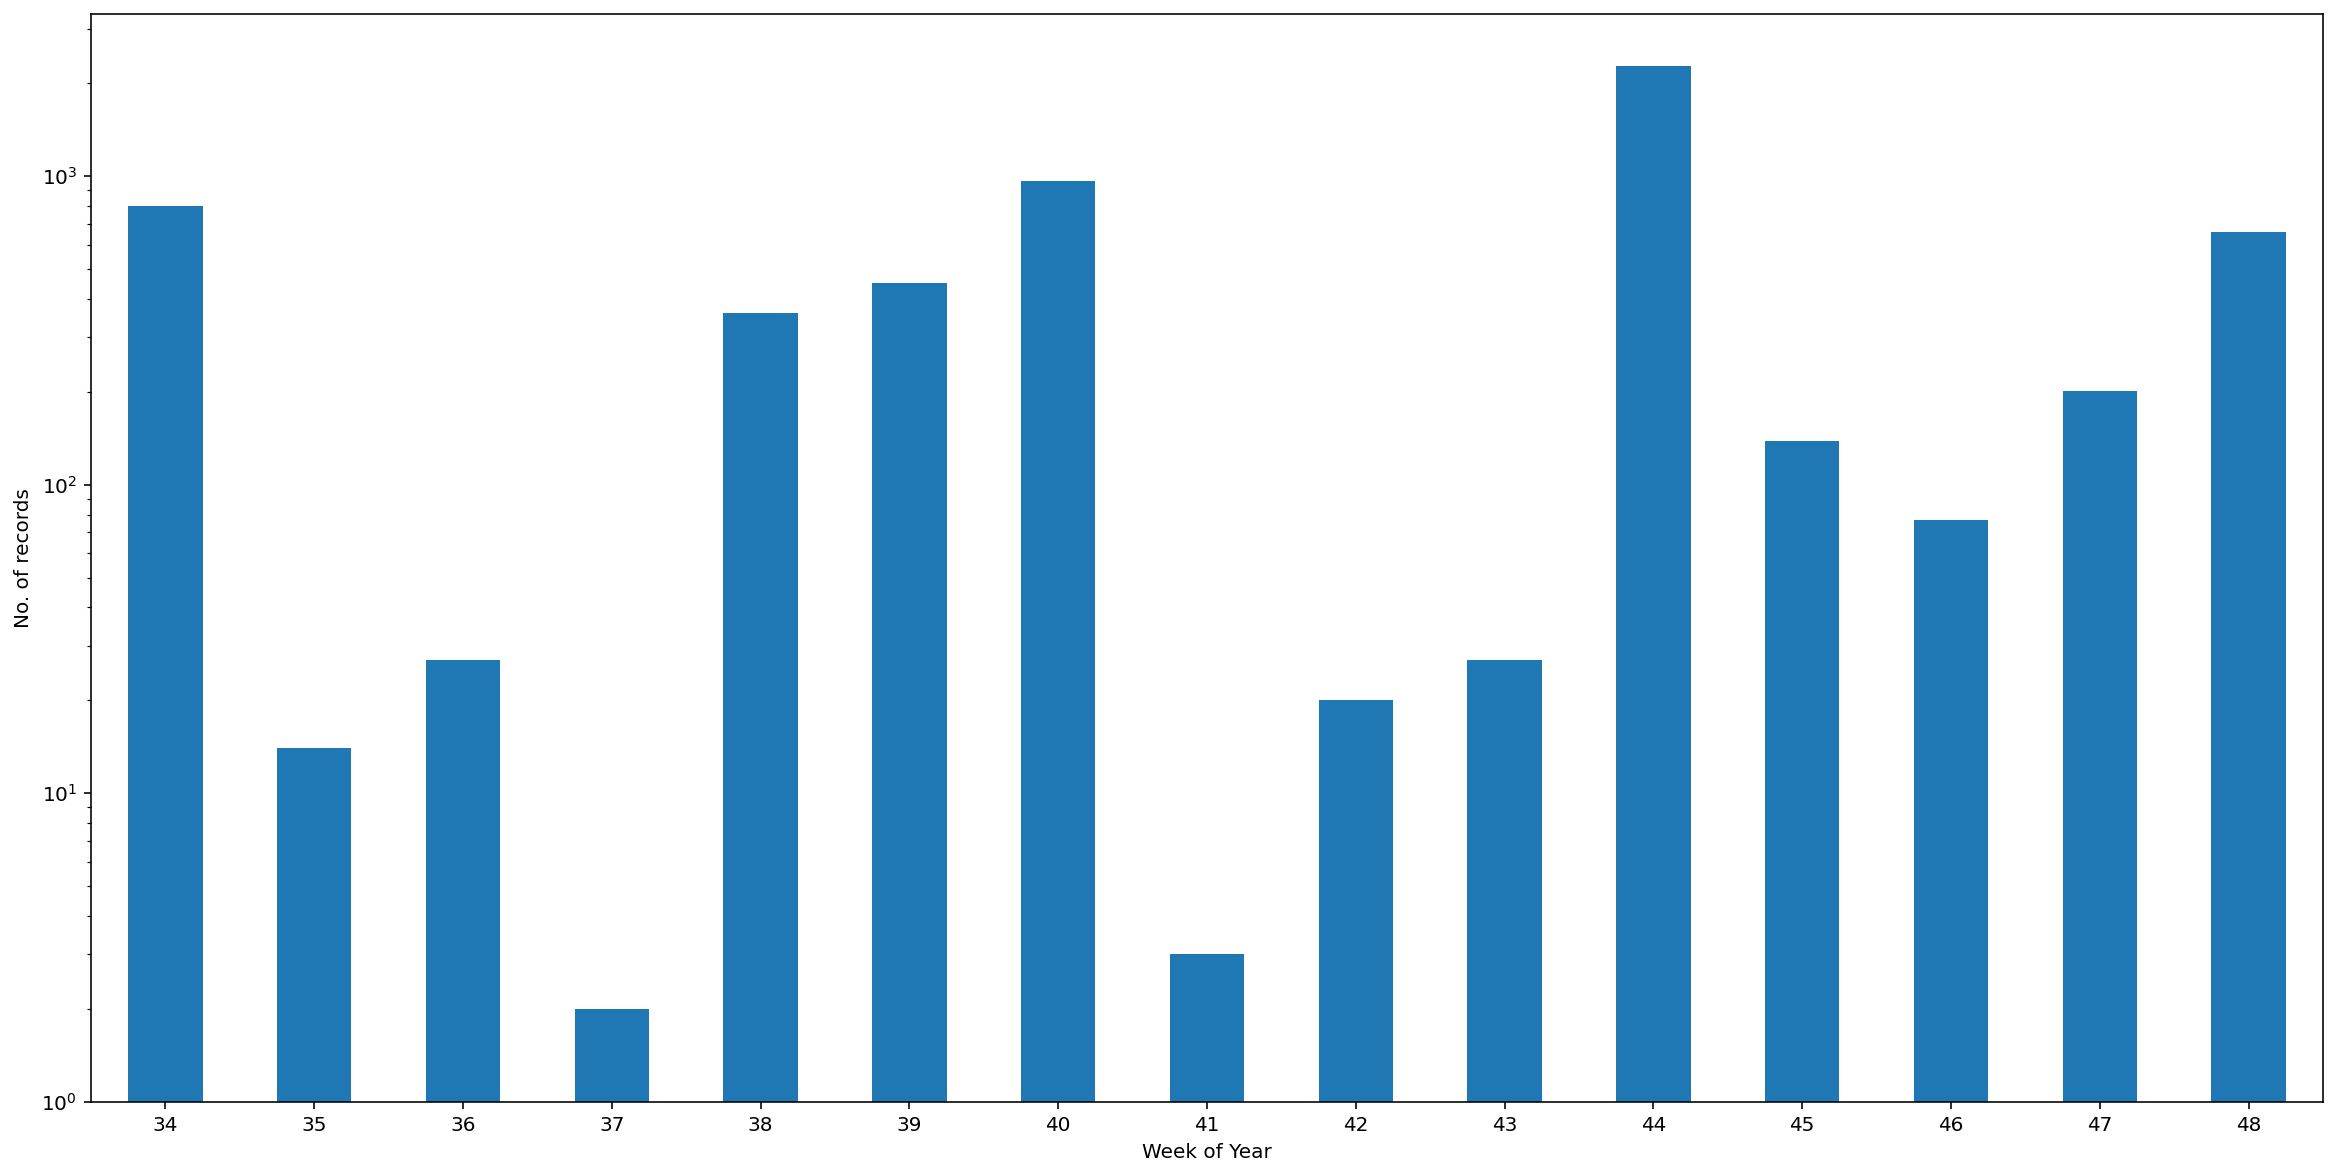

In [ ]:
augmented_activity_df, report = utils.data.build_diachronic_dataframe(
    activity_df, 
    maintainer_df, 
    contributor_prefixes=contributor_prefixes, maintainer_prefixes=maintainers_prefixes)

In [ ]:
report.metrics

,StartPeriod,EndPeriod,ContributorActivityCount,MaintainerActivityCount,ContributorCount,MaintainerCount
0,2020-08-20 09:35:52+00:00,2020-11-23 13:50:52+00:00,3,50,4,29


In [ ]:
report.contributor_activities

array(['Code_Contribution_Aditya_unknown',
       'Code_Contribution_George_Acosta_unknown',
       'Code_Contribution_James_Bond_unknown'], dtype='<U101')

In [ ]:
report.maintainer_activities[0]

'Acknowledgement_and_Response_Greg_Kroah-Hartman_unknown'

In [ ]:
augmented_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 24091 to 883
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   sender_id    5999 non-null   int64              
 1   sent_time    5999 non-null   datetime64[ns, UTC]
 2   triplet_two  5999 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 187.5+ KB


In [ ]:
act2idx, idx2act, act2abbr, abbr2act = report.build_indices()

In [ ]:
utils.common.take_from_dict(1, act2idx)

[('Acknowledgement_and_Response_Greg_Kroah-Hartman_unknown', 0)]

In [ ]:
augmented_activity_df

,sender_id,sent_time,triplet_two
24091,0,2020-08-20 09:35:52+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
24807,0,2020-08-20 09:35:55+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
22403,0,2020-08-20 09:36:02+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
24838,0,2020-08-20 09:36:06+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
23953,0,2020-08-20 09:36:09+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
...,...,...,...
1050,0,2020-11-23 13:34:43+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
1304,0,2020-11-23 13:35:08+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
899,0,2020-11-23 13:35:33+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown
1324,0,2020-11-23 13:35:33+00:00,Code_Contribution_Greg_Kroah-Hartman_unknown


#### 👇 Split timeline into N time periods

In [ ]:
# N is automatically determined based on window_size (default 4),
# and the time unit (default is week)
skipgrams_in_timeline, timeline = utils.data.timeline_slicing(augmented_activity_df, 'triplet_two')

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Distribution of skipgrams in the time frame

Time period 34: 60 skipgrams

Time period 35: 9 skipgrams

Time period 36: 67 skipgrams

Time period 37: 1 skipgrams

Time period 38: 41 skipgrams

Time period 39: 75 skipgrams

Time period 40: 84 skipgrams

Time period 41: 1 skipgrams

Time period 42: 13 skipgrams

Time period 43: 35 skipgrams

Time period 44: 215 skipgrams

Time period 45: 230 skipgrams

Time period 46: 114 skipgrams

Time period 47: 213 skipgrams

Time period 48: 24 skipgrams

,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,537329,37,210,1,88198,158592,859654,4,93,166,3808770,3399,802,9256,429062


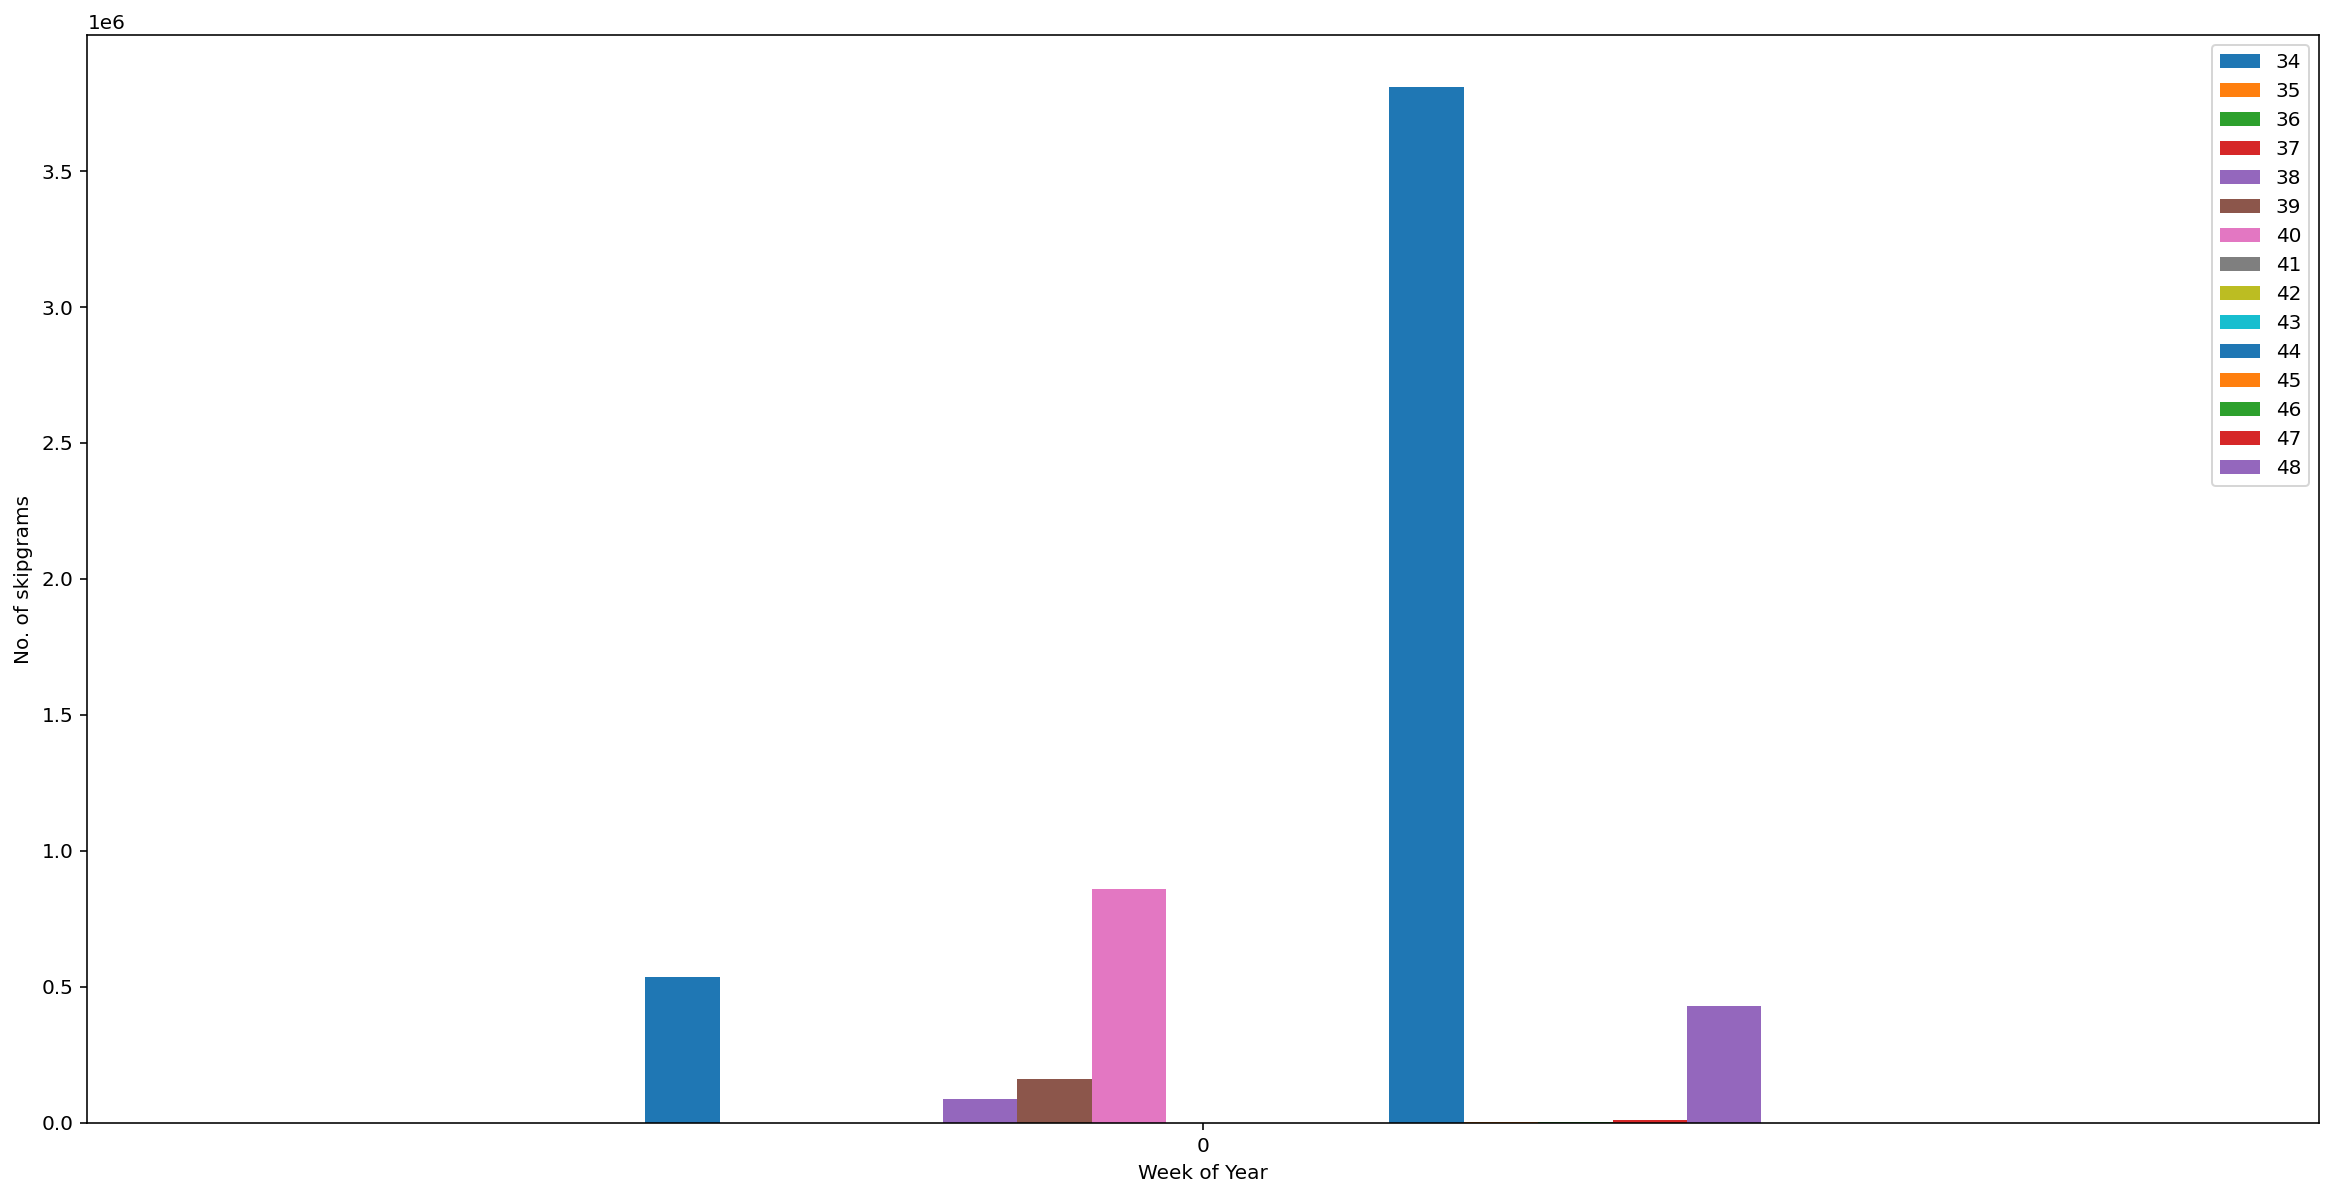

In [ ]:
utils.data.describe_timeline(skipgrams_in_timeline, timeline)

In [ ]:
timeline

array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

#### 👇 Generate Train/Test data

In [ ]:
train_test_by_week = utils.dl.get_train_test_data_per_period(skipgrams_in_timeline, timeline, act2idx)

Output()

In [ ]:
train_test_by_week[0][0][:3]

[(tensor([22, 22]), tensor([22, 22])),
 (tensor([22, 22]), tensor([22, 22])),
 (tensor([22, 22]), tensor([22, 22]))]

#### 👇 Setup Train/Test data and their loaders

In [ ]:
train_test_dataloaders_by_week = utils.dl.get_dataloaders_per_time_slice(train_test_by_week, timeline)

In [ ]:
utils.dl.take_n_from_data_loader(1, list(timeline).index(47), train_test_dataloaders_by_week)

[[tensor([[21, 22],
          [49, 22],
          [22, 22],
          [35, 35],
          [30, 14],
          [39, 42],
          [30, 30],
          [22, 41],
          [12, 22],
          [22, 22]]), tensor([[22, 22],
          [43, 43],
          [22, 22],
          [22, 44],
          [ 3, 42],
          [30, 30],
          [21, 22],
          [22, 22],
          [21, 22],
          [22, 41]])]]

#### Accelerate model with 🤗 and PyTorch 🔥

In [ ]:
accelerator = Accelerator()

In [ ]:
# Reduce the timeline to speed up training and testing
# of 🔥 Activity Skipgram Model
timeline = timeline[:5]

In [ ]:
acceleration_report = utils.dl.accelerate_model(train_test_dataloaders_by_week, timeline, act2idx, accelerator=accelerator)

## 👟 Run the SIGNAL's Activity Skipgram Model with Pytorch 🔥

💪 Run this model to train a simple but effective neural network to generate activity embeddings, using the accelerator API. 

The model is an adaptation of the Skipgram version of Word2Vec, based on earlier time-aware skip grams.

In [ ]:
dynamic_model, training_report = utils.dl.learn_dynamic_activity_model(acceleration_report, timeline, act2idx, idx2act, 1)

EPOCH [TEST] 1 [WEEK] 38...: 100%|██████████| 1323/1323 [00:32<00:00, 41.03it/s, loss=0.000242, acc=97.309146]


[34, 35, 36, 37, 38]


In [ ]:
dynamic_model.get_dynamic_embeddings('Code_Contribution_Aditya_unknown', 0)

array([ 0.00655019, -0.00609713,  0.00617578, -0.00319552, -0.00133198,
        0.01555364,  0.00363074,  0.00328322, -0.00162846, -0.02245832,
       -0.00448473, -0.00923127, -0.00112669,  0.00865714,  0.00161666,
        0.00164539, -0.00332015,  0.00341953,  0.00597896,  0.00762017,
        0.00822758, -0.01308879, -0.00132764, -0.01442246,  0.00103056,
       -0.00531451,  0.00461696,  0.01242285,  0.00568761, -0.01117946,
        0.00294794, -0.00776852, -0.0289625 ,  0.00253605, -0.00270367,
       -0.01234685,  0.0105057 , -0.00956216,  0.005701  , -0.01238616,
       -0.01326007, -0.01013926,  0.01307219,  0.01109655, -0.01343724,
        0.01045609,  0.01618986, -0.00703241, -0.00039648, -0.01596153,
       -0.0144145 , -0.01416766, -0.02165111, -0.01211901, -0.00884546,
       -0.02034597,  0.00885485,  0.01263949, -0.00385939,  0.00482683,
       -0.01451225,  0.01911988,  0.02119213, -0.01022996, -0.01795389,
       -0.0313614 , -0.00052099, -0.00719477, -0.00028937, -0.01

In [ ]:
training_report.metrics

The above summaries show a very good performance of our Skipgram model for developer activity. 

Next, we show the embedding space of developer activities. For sake of presentation, the long activity names were replaced by a shorter version. E.g., a `Code_Contribution_John_Doe_Stringy` would be abbreviated as `CCJDS`.

# 👀 Tracking Activity Evolution Across Time frames 📅 

## 👉 Signal drifts and "evolution" trajectory 🚐 of selected 🤸 activities

### 📽 Visualize drifts in vector norms

In [ ]:
all_activities = np.union1d(report.contributor_activities, report.maintainer_activities)
len(all_activities)

53

In [ ]:
sample_query = utils.arrays.get_random_elements(all_activities, 3)
sample_query

array(['Code_Contribution_Vivek_Goyal_unknown',
       'Code_Contribution_Andrew_Lunn_stringy',
       'Code_Contribution_Kees_Cook_stringy'], dtype='<U101')

In [ ]:
timeline_slice_aligned_models = [dynamic_model.embeddings[t] for t in range(len(dynamic_model.embeddings))]

In [ ]:
aligned_vectors_norm = utils.ml.get_vector_norms(sample_query, timeline_slice_aligned_models, training_report.timeline_slices, act2idx)

In [ ]:
aligned_vectors_norm

[array([0.2292944 , 0.19861859, 0.20904549, 0.20124075, 0.16180076]),
 array([0.18952675, 0.23496437, 0.18682677, 0.21137416, 0.17730795]),
 array([0.21594927, 0.20282856, 0.23106587, 0.20810915, 0.14204715])]

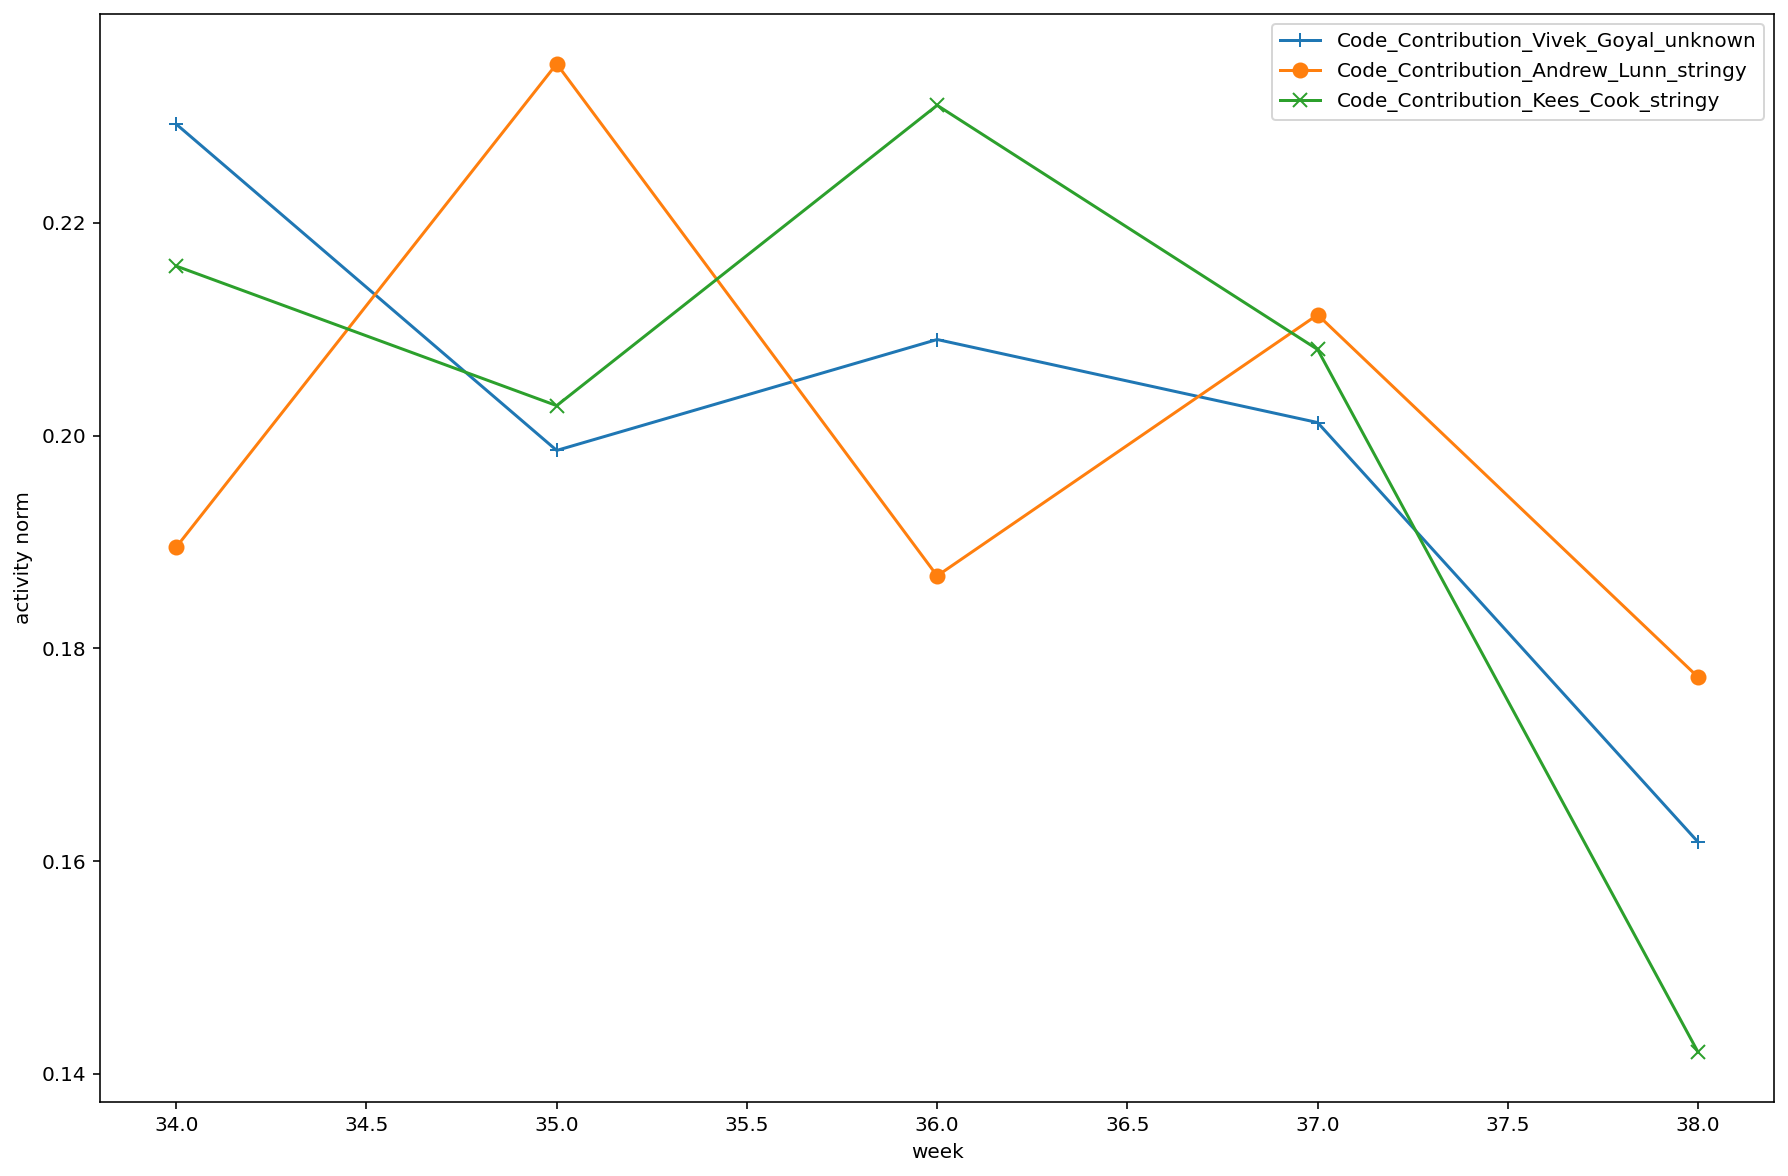

In [ ]:
utils.plots.plot_embedding_changes_in_vector_space(sample_query, aligned_vectors_norm, timeline)

The normal evolution of activity embeddings is expected to have a vector norm within `0.14-0.18`. Clearly, the activity embeddings of aliases used in the hyprocrite commints incident go out of this range; e.g., for George Acosta, his activities go beyond `0.20` in week `35` onwards.

### 🐇 Follow the evolution trajectory of activities

💪 Inspired by work in tracking word evolution in NLP research (e.g., Yao et al. 2018), we focus on tracking the evolution of activities performed developers in the LKML. We partition this dataset into different time frames (e.g., weeks, months, or years) and compute time-aware embeddings for each LKML activity. Specifically, each activity in a time frame is represented by a different vector. In this context, tracking the evolution of activities refers to the changing of meanings and associations of activities throughout time, as a byproduct of developer behavior evolution. By studying activity evolution, we hope to infer behavioral trends over different periods of developer activity history in the LKML.

In [ ]:
minnesota_activities = report.contributor_activities
minnesota_activities

array(['Code_Contribution_Aditya_unknown',
       'Code_Contribution_George_Acosta_unknown',
       'Code_Contribution_James_Bond_unknown'], dtype='<U101')

In [ ]:
# Generate TSNE projections for query elements
query_package = utils.ml.build_tsne_projections(minnesota_activities, timeline, dynamic_model, act2idx, idx2act)

In [ ]:
# query_package
query_package[utils.common.take(1, minnesota_activities)[0]].N[:3]

[('Code_Contribution_Aditya_unknown', 34),
 ('Code_Contribution_Jiri_Slaby_unknown', 34),
 ('Code_Contribution_Denis_Efremov_unknown', 34)]

In [ ]:
linux_activities = set(report.maintainer_activities)

In [ ]:
minnesota_activities

array(['Code_Contribution_Aditya_unknown',
       'Code_Contribution_George_Acosta_unknown',
       'Code_Contribution_James_Bond_unknown'], dtype='<U101')

In [ ]:
[a for a in all_activities if a in minnesota_activities]

['Code_Contribution_Aditya_unknown',
 'Code_Contribution_George_Acosta_unknown',
 'Code_Contribution_James_Bond_unknown']

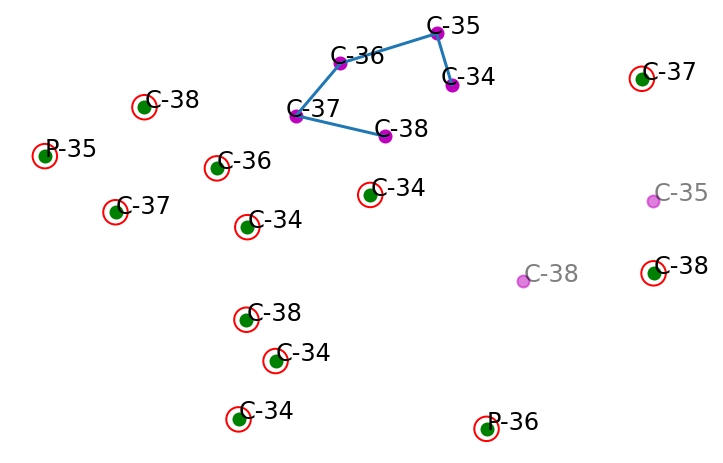

array([[22.599287, 45.346485],
       [ 6.252838, 54.107582],
       [14.431138, 76.281395],
       [32.15733 , 88.931404],
       [34.987434, 67.13427 ]], dtype=float32)

In [ ]:
utils.ml.tracking_moving_activity('Code_Contribution_Aditya_unknown', query_package, set(minnesota_activities), linux_activities, act2abbr, dynamic_model, timeline, filter_ctx_activities = True)

In [ ]:
dynamic_model.k_nearest('Code_Contribution_Aditya_unknown')

array([[['Code_Contribution_Jiri_Slaby_unknown', '0.2561490934635938'],
        ['Code_Contribution_Denis_Efremov_unknown',
         '0.1989147411561865'],
        ['Code_Contribution_Viresh_Kumar_stringy',
         '0.17379579165971643'],
        ['Patch_Posting_Andreas_Gruenbacher_unknown',
         '0.17129106523650087'],
        ['Code_Contribution_Vladimir_Zapolskiy_unknown',
         '0.1642599319122458']],

       [['Code_Contribution_Andrew_Morton_stringy',
         '0.22814308240758724'],
        ['Code_Contribution_James_Bond_unknown', '0.22045326975596202'],
        ['Patch_Posting_Miquel_Raynal_unknown', '0.18030779921850948'],
        ['Code_Contribution_Alan_Stern_stringy', '0.1556666225117646'],
        ['Code_Contribution_Ahmad_Fatoum_unknown',
         '0.13837239970825743']],

       [['Code_Contribution_Weili_Qian_unknown', '0.17050210067062818'],
        ['Code_Contribution_Vlastimil_Babka_unknown',
         '0.17032417069999'],
        ['Code_Contribution_Andrew_Mo

In the above images, maintainer actions (green markers) close to hypocrite commit actions are marked with red circles. If one follows the evolution trajectory of hypocrite commits (red dot) across many weeks, one can see an increase of maintainer actions close to these hypocrite commits actions, suggesting an trust ascendancy of these actions.

## &#128071; What's next?

&#128072; [Installation and Dashboard Visualization](https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/demo/01_installation_and_dashboard.ipynb)

&#128072; [Activity and Role Detection in LKML](https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/demo/02_activity_roles_detection.ipynb)

&#128073; [Code Landmarks Detection](https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/demo/04_code_landmarks_detection.ipynb)